## Import libraries

In [134]:
import pandas as pd
import numpy as np
from pandas import Series
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pyramid.arima import auto_arima
import matplotlib 

matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import math

## Import datasets for analysis

In [1]:
uber_apr = pd.read_csv("C:\Users\Aastha\Documents\Summer\Uber\uber-raw-data-apr14.csv")
uber_may = pd.read_csv("C:\Users\Aastha\Documents\Summer\Uber\uber-raw-data-may14.csv")
uber_jun = pd.read_csv("C:\Users\Aastha\Documents\Summer\Uber\uber-raw-data-jun14.csv")
uber_jul = pd.read_csv("C:\Users\Aastha\Documents\Summer\Uber\uber-raw-data-jul14.csv")
uber_aug = pd.read_csv("C:\Users\Aastha\Documents\Summer\Uber\uber-raw-data-aug14.csv")
uber_sep = pd.read_csv("C:\Users\Aastha\Documents\Summer\Uber\uber-raw-data-sep14.csv")


NameError: name 'pd' is not defined

## Data cleaning and manipulation

In [181]:
#combining all months to a single data frame
uber_data = pd.concat([uber_apr,uber_may,uber_jun,uber_jul,uber_aug,uber_sep])

uber_data.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [4]:
#checking if any null values present in this dataset
uber_data.isnull().any()


Date/Time    False
Lat          False
Lon          False
Base         False
dtype: bool

### No null or missing values present in the final data frame

### The data needs to be converted to a time series with daily ridership 

In [6]:
#Converting the dates to Index in the dataframe
uber_data.set_index(pd.DatetimeIndex(uber_data['Date/Time']),inplace=True)
uber_data.index = pd.to_datetime(uber_data.index).date

#grouping by the date to find out ridership for each date from April,2014 to Sep,2014
uber_data_ts = uber_data.groupby(uber_data.index).size()

#sample of the time series
uber_data_ts.head()

,Date/Time,Lat,Lon,Base
2014-04-01,4/1/2014 0:11:00,40.7690,-73.9549,B02512
2014-04-01,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2014-04-01,4/1/2014 0:21:00,40.7316,-73.9873,B02512
2014-04-01,4/1/2014 0:28:00,40.7588,-73.9776,B02512
2014-04-01,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [2]:
uber_data_ts.plot()
plt.show()

NameError: name 'uber_data_ts' is not defined

## Goal - To find ride estimations for last week of September

### Take out holdout test for final evaluation - 1 week

In [187]:
split_point = len(uber_data_ts) - 7
dataset, holdout = uber_data_ts[0:split_point], uber_data_ts[split_point:]
print('Days in Training Data - %d\nDays in Holdout Data - %d' % (len(dataset), len(holdout)))

Days in Training Data - 176
Days in Holdout Data - 7


### To check if the time series has an AR, MA or a random walk component, we need to do ACF, PACF and ADFuller Test

### ACF test shows if the Time series has an MA component, PACF test shows if there is any AR component

<IPython.core.display.Javascript object>


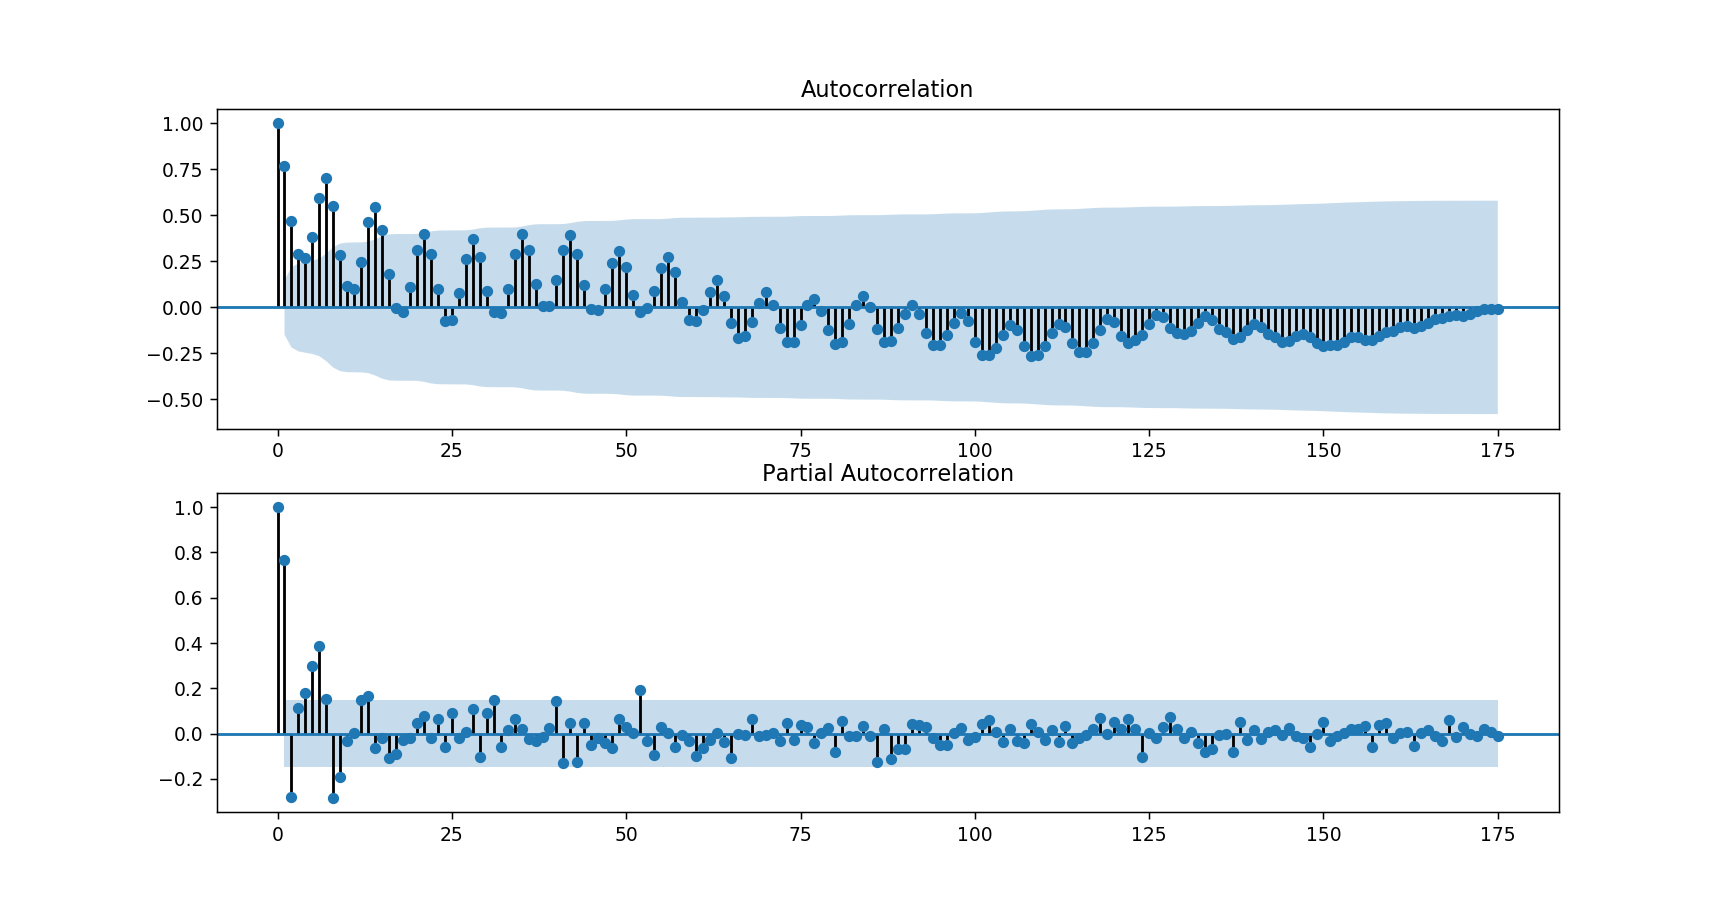

In [193]:
#plotting acf and pacf for the training data
plt.figure()
plt.subplot(211)
plot_acf(dataset, ax=plt.gca())
plt.subplot(212)
plot_pacf(dataset, ax=plt.gca())
plt.show()

### From the figure above we can see that there are no only MA or AR components. We need to check if there is a random walk component. This can be done using ADFuller test

In [195]:
#stationarity check
result = adfuller(dataset)
print('p-value: %f' % result[1])

p-value: 0.842868


### Since the p-value is not significantly low, we can not reject the hypothesis that there is no random walk component.

### Taking one difference in the time series to check if the difference series follow ARMA

In [197]:
# create a differece function
#subtract previous observation
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return Series(diff)

#only values from the training data
X = dataset.values

# difference data
stationary_diff = difference(X)
stationary_diff.index = dataset.index[1:]

#ADFuller test to check if there is still a random walk component
result_diff = adfuller(stationary_diff)
print('p-value: {}'.format(result_diff[1]))



p-value: 2.18721616489e-08


### From the p-value in differences - we can say that there was only one random walk component in the series

### We can now plot the acf and pacf graphs to see what the other characteristics of the first difference is

<IPython.core.display.Javascript object>


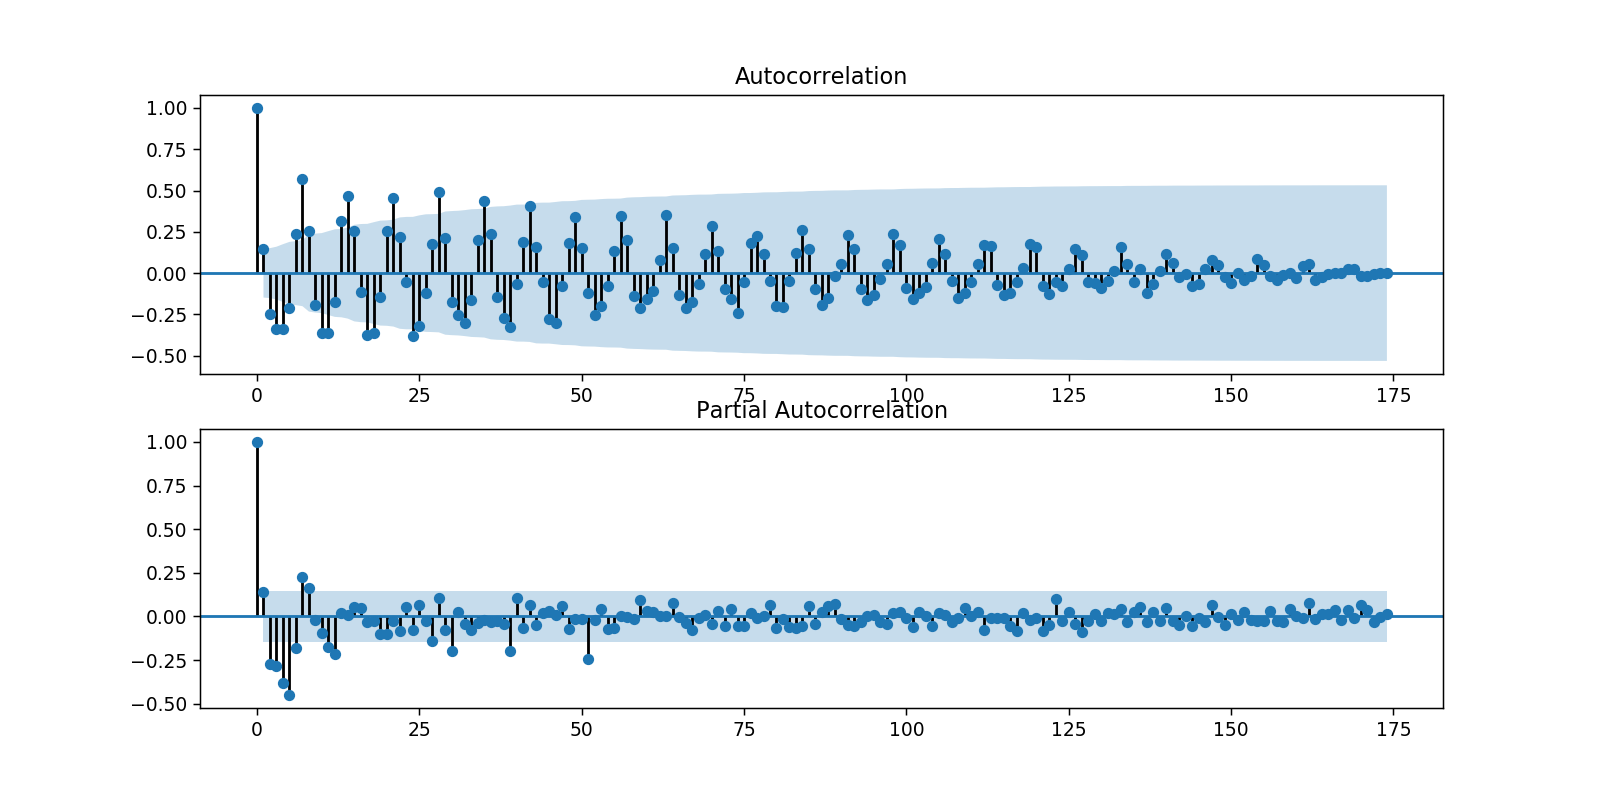

In [199]:
#plots on difference
plt.figure()
plt.subplot(211)
plot_acf(stationary_diff, ax=plt.gca())
plt.subplot(212)
plot_pacf(stationary_diff, ax=plt.gca())
plt.show()

### Even though there is no random walk component present in the first differences, there is still no clear picture of the AR and MA components from the graphs. But here we do see that there is a seasonality of 7 present

### To find out what AR and MA values the original training data has, we use the auto_arima funtion 

In [200]:
#fitting the auto_arima to the training dataset 
stepwise_fit = auto_arima(dataset, start_p=0, start_q=0, max_p=3, max_q=3, m=7,
                          start_P=0, seasonal=True,d=1, D=1,trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 8); AIC=3319.758, BIC=3329.269, Fit time=0.575 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 8); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 8); AIC=3354.913, BIC=3367.595, Fit time=0.316 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 8); AIC=3316.009, BIC=3328.691, Fit time=1.270 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 8); AIC=3308.351, BIC=3324.203, Fit time=1.711 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 8); AIC=3354.539, BIC=3367.221, Fit time=0.266 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 8); AIC=3320.447, BIC=3339.470, Fit time=1.825 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 8); AIC=3361.385, BIC=3370.897, Fit time=0.143 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 8); AIC=3320.298, BIC=3342.491, Fit time=2.405 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 8)   Log Likelihood               -1630.886
Date:                           Sun, 01 Apr 2018   AIC                           3275.771
Time:                                   23:47:49   BIC                           3297.964
Sample:                                        0   HQIC                          3284.773
                                           - 176                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.5314      1.987     -0.771      0.441      -5.426       2.363
ar.L1          0.8698      0.060     14.536      0.000       0.753       0.987
ar.L2         -0.3378      0.078     -4.347      0.000      -0.490      -0.185
ma.L1         -0.9940      0.127     -7.837      0.000      -1.243      -0.745
ar.S.L8        0.1876      0.089      2.107      0.035       0.013       0.362
ma.S.L8       -0.9935      0.141     -7.034      0.000      -1.270      -0.717
sigma2      1.475e+07    1.1e-08   1.34e+15      0.000    1.48e+07    1.48e+07
===================================================================================
Ljung-Box (Q):                      153.37   Jarque-Bera (JB):                 8.30
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.62   Skew:                            -0.43
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+32. Standard errors may be unstable.
"""

### Using the top 2 models with least AIC to do a window forecast and then choose the best model. These are ARIMA(1,1,1)(0,1,1)[7] and ARIMA(0, 1, 1)(0, 1, 1)[7]

In [188]:
#find the average rmse with ARIMA(1,1,1)(0,1,1)[7] 
rmse = []
for i in xrange(42,169-7,7):
    intermediate_train = train[0:i]
    intermediate_test = train[i:i+7]
    model = sm.tsa.statespace.SARIMAX(intermediate_train, trend='n', order=(1,1,1), seasonal_order=(0,1,1,7))
    results = model.fit()
    results_ARIMA = results.predict(disp=1,start=i,end=i+6)
    error = mean_squared_error(intermediate_test, results_ARIMA)
    rmse.append( math.sqrt(error))

In [206]:
print ('Average RMSE using ARIMA(1,1,1)(0,1,1)[7] - {}'.format(np.mean(rmse)))

Average RMSE using ARIMA(1,1,1)(0,1,1)[7] - 3741.55655682


In [190]:
#find the average rmse with ARIMA(0,1,1)(0,1,1)[7] 
rmse_2 = []
for i in xrange(42,169-7,7):
    intermediate_train = train[0:i]
    intermediate_test = train[i:i+7]
    model = sm.tsa.statespace.SARIMAX(intermediate_train, trend='n', order=(0,1,1), seasonal_order=(0,1,1,7))
    results = model.fit()
    results_ARIMA = results.predict(disp=1,start=i,end=i+6)
    error = mean_squared_error(intermediate_test, results_ARIMA)
    rmse_2.append( math.sqrt(error))

In [207]:
print ('Average RMSE using ARIMA(0,1,1)(0,1,1)[7] - {}'.format(np.mean(rmse_2)))

Average RMSE using ARIMA(0,1,1)(0,1,1)[7] - 3810.97637395


### Selecting the model with least RMSE - Seasonal ARIMA(1,1,1)(0,1,1)[7]

### Use this model to predict for the holdout data 

RMSE 1995.75707849


<IPython.core.display.Javascript object>


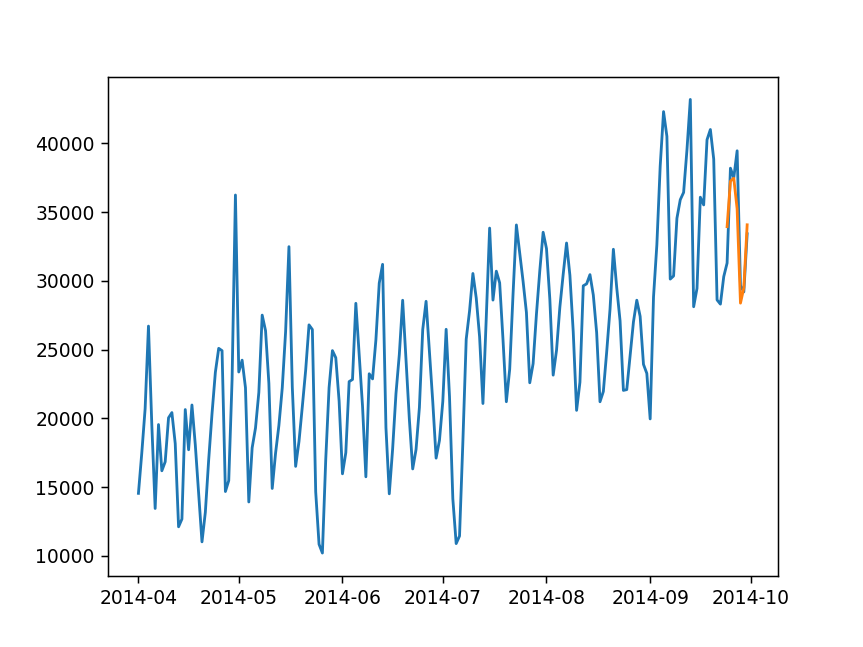

In [192]:
final_model = sm.tsa.statespace.SARIMAX(dataset, trend='n', order=(1,1,1), seasonal_order=(0,1,1,7))
final_results = final_model.fit()
final_results_ARIMA = final_results.predict(disp=1,start=176,end=176+6)

error = mean_squared_error(holdout, final_results_ARIMA)
print ("RMSE {}".format(math.sqrt(error)))

plt.plot(uber_data_ts)
plt.plot(final_results_ARIMA)
plt.show()